#### Import the relevant packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.exceptions import FitFailedWarning

#### Step 1: Load Data & Data Preprocessing 

In [2]:
# Load and preprocess data
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locaions_Updated_1.csv"  # Define the path to the dataset
Complete_Data = pd.read_csv(data_path)  # Load the dataset into a DataFrame

# Convert 'Date' column to datetime format and encode 'Source' as numeric codes
Complete_Data['Date'] = pd.to_datetime(Complete_Data['Date'], format='%Y-%m-%d')
Complete_Data['Source_ID'] = Complete_Data['Source'].astype('category').cat.codes + 1

# Remove unnecessary columns for analysis
filtered_df = Complete_Data.drop(columns=[
    'Day_of_Year', 'Source',
    'SWCT_005', 'STMP_005', 'NEE_CO2', 'NEE_CO2_MDS', 
    'NEE_CH4', 'NEE_CH4_MDS', 'NEE_H2O'])

# Filter data from 2020 onwards and scale 'SWCT_015' values
filtered_df = filtered_df[filtered_df['Date'] >= '2020-01-01']
filtered_df['SWCT_015'] = filtered_df['SWCT_015'] / 100

# Drop rows with NaNs in 'SWCT_015' directly when defining X, y, and groups
non_na_data = filtered_df.dropna(subset=['SWCT_015'])
X = non_na_data.drop(columns=["SWCT_015", "Date"])  # Define X as features excluding the target and Date
y = non_na_data["SWCT_015"]                         # Define y as the target variable
groups = non_na_data["Source_ID"]                   # Define groups for Leave-One-Group-Out cross-validation

# Split the data into training and test sets
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42)

# Print dimensions of the data after handling NaNs and splitting
print("Data shapes after NaN handling and splitting:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("groups_train:", groups_train.shape)
print("groups_test:", groups_test.shape)

# Ensure data alignment between X_train and y_train
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
groups_train = groups_train.loc[X_train.index]  # Align groups_train to X_train indices

# Check for alignment
if X_train.index.equals(y_train.index) and X_train.index.equals(groups_train.index):
    print("\nRows in X_train, y_train, and groups_train are aligned.")
else:
    print("\nWarning: Rows in X_train, y_train, and groups_train are misaligned!")

Data shapes after NaN handling and splitting:
X_train: (6858, 12)
y_train: (6858,)
X_test: (1715, 12)
y_test: (1715,)
groups_train: (6858,)
groups_test: (1715,)

Rows in X_train, y_train, and groups_train are aligned.


#### Step 2: Hyperparameter Tuning

In [3]:
# Define the RandomForestRegressor model and create a pipeline
rf = RandomForestRegressor(random_state=0)
pipeline = Pipeline([("randomforestregressor", rf)])

# Define parameter grid for GridSearchCV
param_grid = {
    "randomforestregressor__n_estimators": [300, 400, 500, 600, 700],
    "randomforestregressor__max_depth": [5, 10, 15],
    "randomforestregressor__max_features": ["sqrt", "log2", None],
    "randomforestregressor__min_samples_leaf": [1, 2, 4]}

# Suppress warnings except for FitFailedWarning, which indicates issues during fitting
warnings.simplefilter("error", FitFailedWarning)

# Initialize GridSearchCV with Leave-One-Group-Out cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=LeaveOneGroupOut().split(X_train, y_train, groups=groups_train),
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    error_score=np.nan)  # Set failed fits to NaN

# Fit GridSearchCV with error handling
try:
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_  # Best parameters found by GridSearchCV
    best_score = grid_search.best_score_    # Best cross-validation score
    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score:", best_score)
except FitFailedWarning as e:
    print("FitFailedWarning encountered during fitting:")
    print(str(e))
except ValueError as ve:
    print("ValueError encountered during fitting:")
    print(str(ve))
except AttributeError:
    print("GridSearchCV did not complete successfully; best parameters and score are unavailable.")

Best Parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 400}
Best Cross-Validation Score: -0.008283352181404255


#### Step 3: Train the selected model with specific variables

In [4]:
# Generate predictions on the test set if fitting was successful
if "best_params_" in grid_search.__dict__:
    best_model = grid_search.best_estimator_   # Use the best estimator found by GridSearchCV
    y_pred = best_model.predict(X_test)        # Predict on the test set

    # Check for NaN values in y_test and y_pred
    if np.isnan(y_test).any():
        print("Warning: y_test contains NaN values.")
    else:
        print("y_test does not contain NaN values.")

    if np.isnan(y_pred).any():
        print("Warning: y_pred contains NaN values.")
    else:
        print("y_pred does not contain NaN values.")

    # Calculate evaluation metrics if there are no NaNs in y_test or y_pred
    if not np.isnan(y_test).any() and not np.isnan(y_pred).any():
        metrics = {
            "R2 Score": r2_score(y_test, y_pred),                 # R-squared Score
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # Root Mean Squared Error
            "MAE": mean_absolute_error(y_test, y_pred)            # Mean Absolute Error
        }
        print("Evaluation Metrics:", metrics)
    else:
        print("Evaluation metrics could not be calculated due to NaN values in y_test or y_pred.")
else:
    print("Skipping predictions and evaluation as the model training was incomplete.")

y_test does not contain NaN values.
y_pred does not contain NaN values.
Evaluation Metrics: {'R2 Score': 0.8270265672064884, 'RMSE': 0.06547479860446893, 'MAE': 0.036663080479129105}


#### Step 4: Compute and plot Shapley Values

In [7]:
explainer = shap.TreeExplainer(best_model['randomforestregressor'])
shap_values = explainer.shap_values(X_test)         # Calculate SHAP values
print("SHAP values shape:", shap_values.shape)      # Inspect the shape of shap_values
print("SHAP values datatype:", type(shap_values))   # Inspect the datatype of shap_values

base_values = explainer.expected_value              # Model's expected output as baseline
feature_data = X_test.values                        # Feature data for each instance
feature_names = X_test.columns.tolist()             # List of feature names

# Construct the shap.Explanation object
shap_values_explanation = shap.Explanation(
    values=shap_values,                           # SHAP values from explainer
    base_values=base_values,                      # Expected base value from explainer
    data=feature_data,                            # Feature data (input values)
    feature_names=feature_names)                  # Feature names

SHAP values shape: (1715, 12)
SHAP values datatype: <class 'numpy.ndarray'>


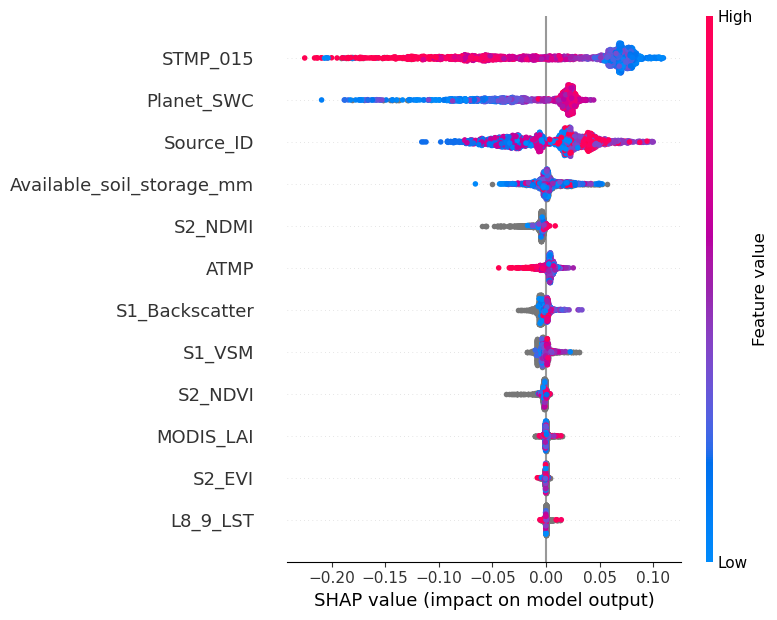

In [8]:
# Plot SHAP summary for feature importance
shap.summary_plot(shap_values, X_test)                               

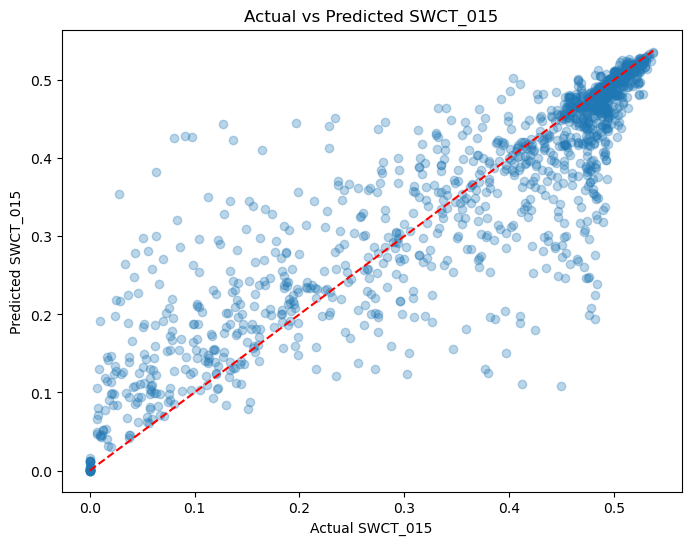

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SWCT_015")
plt.ylabel("Predicted SWCT_015")
plt.title("Actual vs Predicted SWCT_015")
plt.show()

#### Plot multiple Shapley scatter plots of Planet_SWC

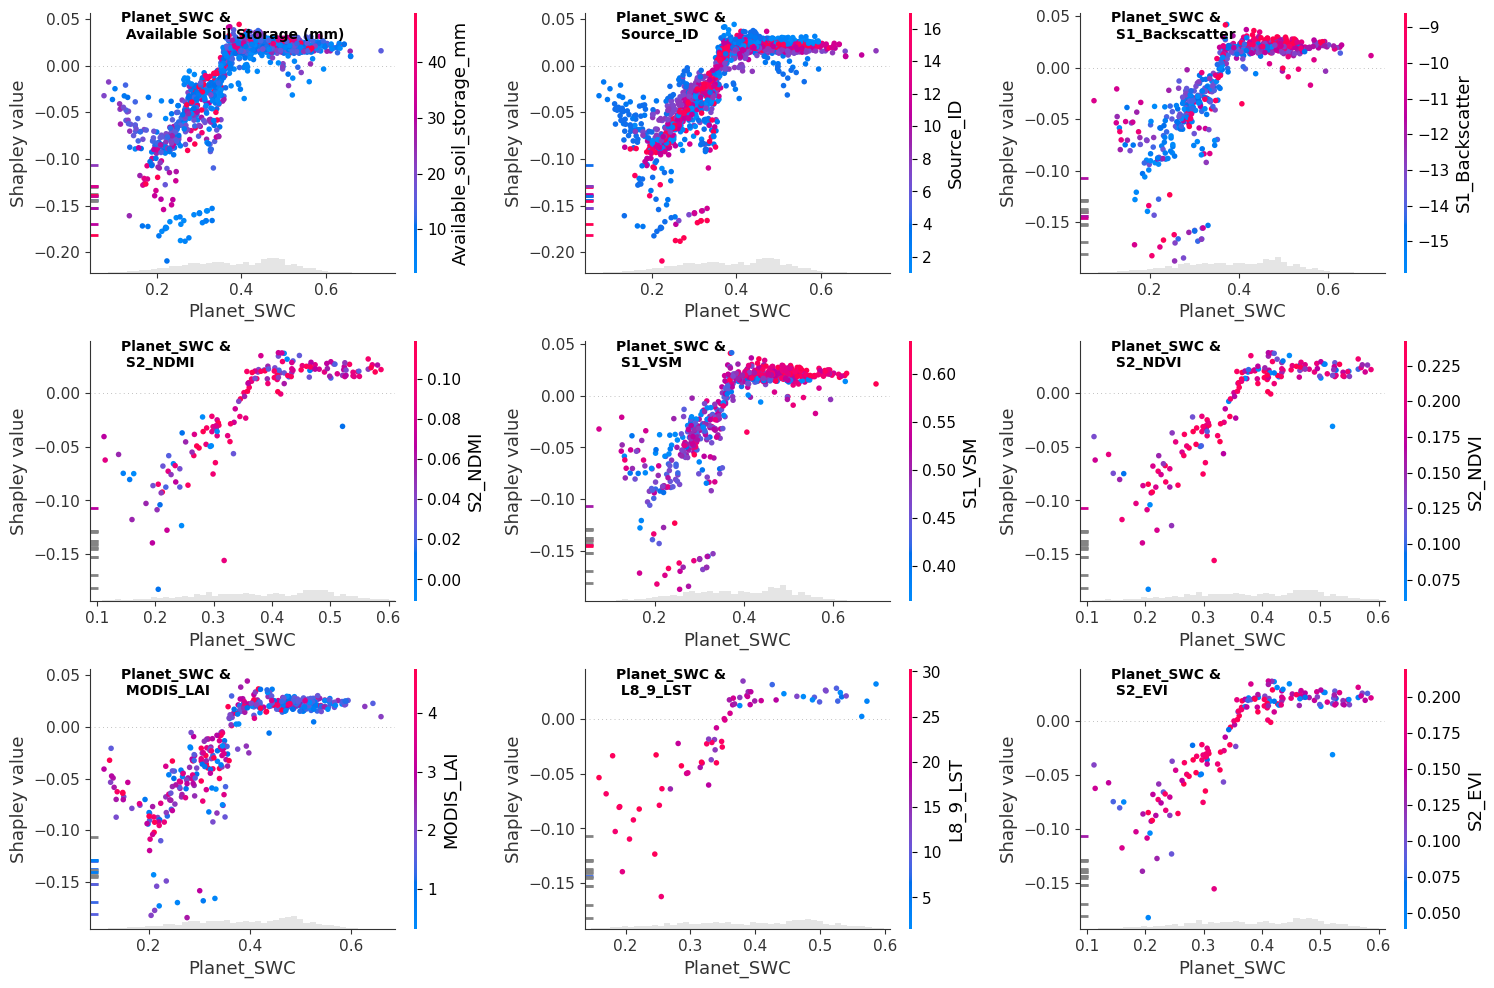

In [9]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

### AX1
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'Available_soil_storage_mm'], 
                   show=False,ax=ax1,ylabel=None)
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('Planet_SWC')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'Planet_SWC &\n Available Soil Storage (mm)', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'Source_ID'],
                   show=False,ax=ax2,ylabel=None)
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('Planet_SWC')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'Planet_SWC &\n Source_ID', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'S1_Backscatter'],
                   show=False,ax=ax3,ylabel=None)
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('Planet_SWC')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'Planet_SWC &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('Planet_SWC')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'Planet_SWC &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'], 
                   color=shap_values_explanation[:, 'S1_VSM'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('Planet_SWC')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'Planet_SWC &\n S1_VSM', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('Planet_SWC')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'Planet_SWC &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'MODIS_LAI'],
                   show=False,ax=ax7,ylabel=None)
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('Planet_SWC')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'Planet_SWC &\n MODIS_LAI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'], 
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax8,ylabel=None)
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('Planet_SWC')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'Planet_SWC &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Planet_SWC'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax9,ylabel=None)
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('Planet_SWC')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'Planet_SWC &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

#### Plot multiple Shapley scatter plots of Available_soil_storage_mm

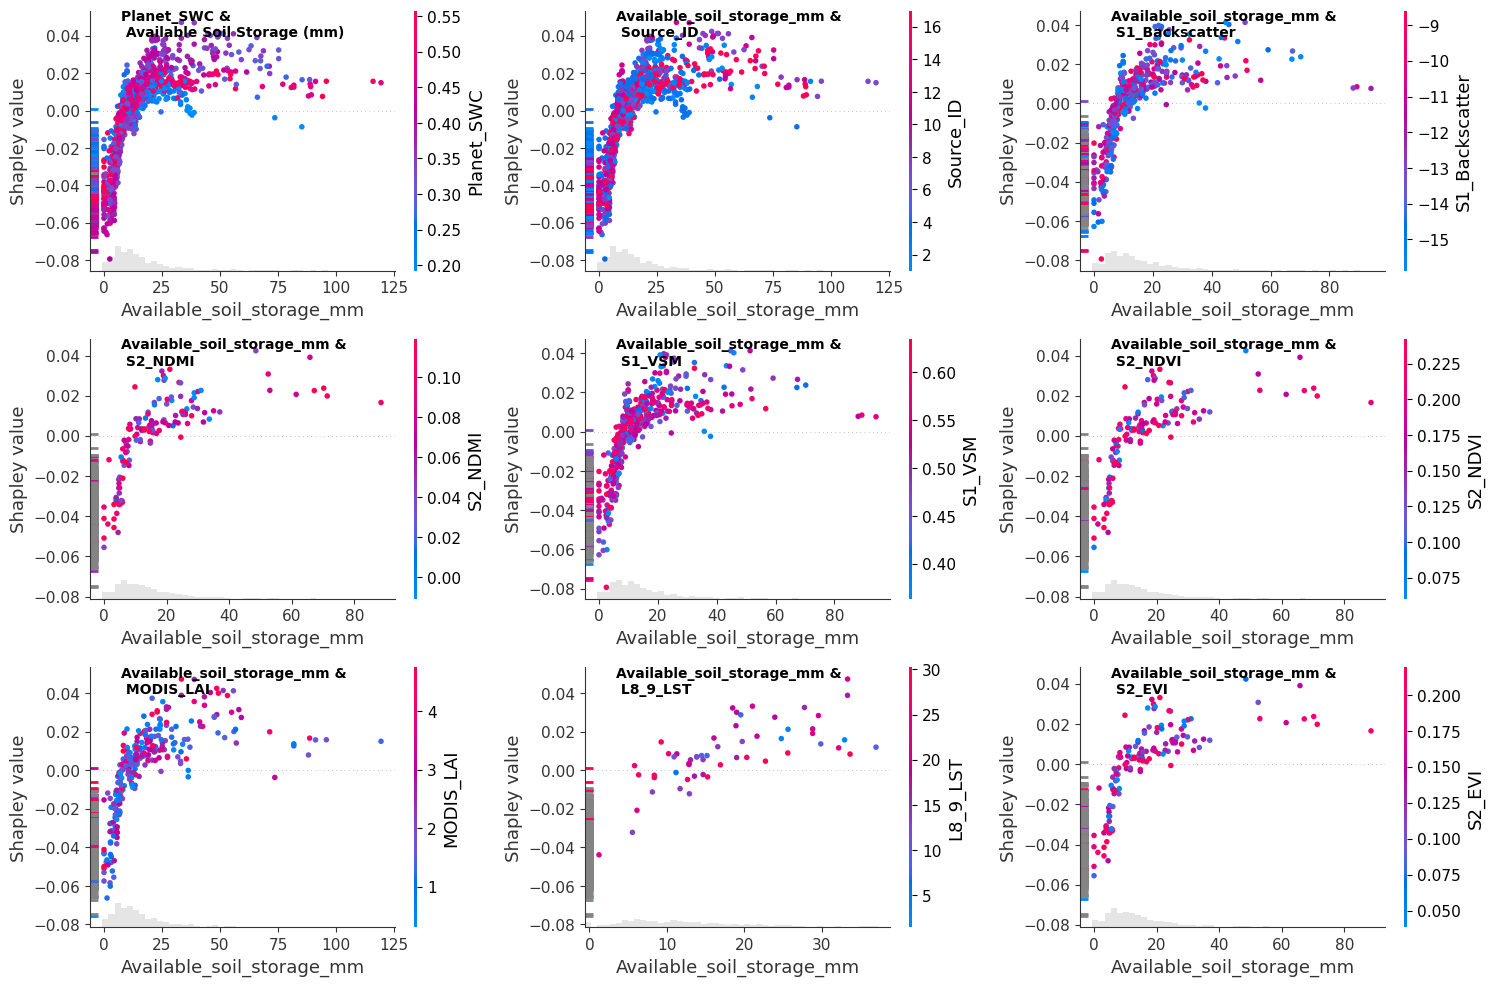

In [52]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

### AX1 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'Planet_SWC'], 
                   show=False,ax=ax1,ylabel=None)
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('Available_soil_storage_mm')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'Available Soil Storage (mm) &\n Planet_SWC', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'Source_ID'],
                   show=False,ax=ax2,ylabel=None)
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('Available_soil_storage_mm')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'Available_soil_storage_mm &\n Source_ID', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'S1_Backscatter'],
                   show=False,ax=ax3,ylabel=None)
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('Available_soil_storage_mm')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'Available_soil_storage_mm &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('Available_soil_storage_mm')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'Available_soil_storage_mm &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'], 
                   color=shap_values_explanation[:, 'S1_VSM'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('Available_soil_storage_mm')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'Available_soil_storage_mm &\n S1_VSM', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('Available_soil_storage_mm')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'Available_soil_storage_mm &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'MODIS_LAI'],
                   show=False,ax=ax7,ylabel=None)
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('Available_soil_storage_mm')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'Available_soil_storage_mm &\n MODIS_LAI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'], 
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax8,ylabel=None)
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('Available_soil_storage_mm')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'Available_soil_storage_mm &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Available_soil_storage_mm'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax9,ylabel=None)
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('Available_soil_storage_mm')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'Available_soil_storage_mm &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

#### Plot multiple Shapley scatter plots of Source_ID

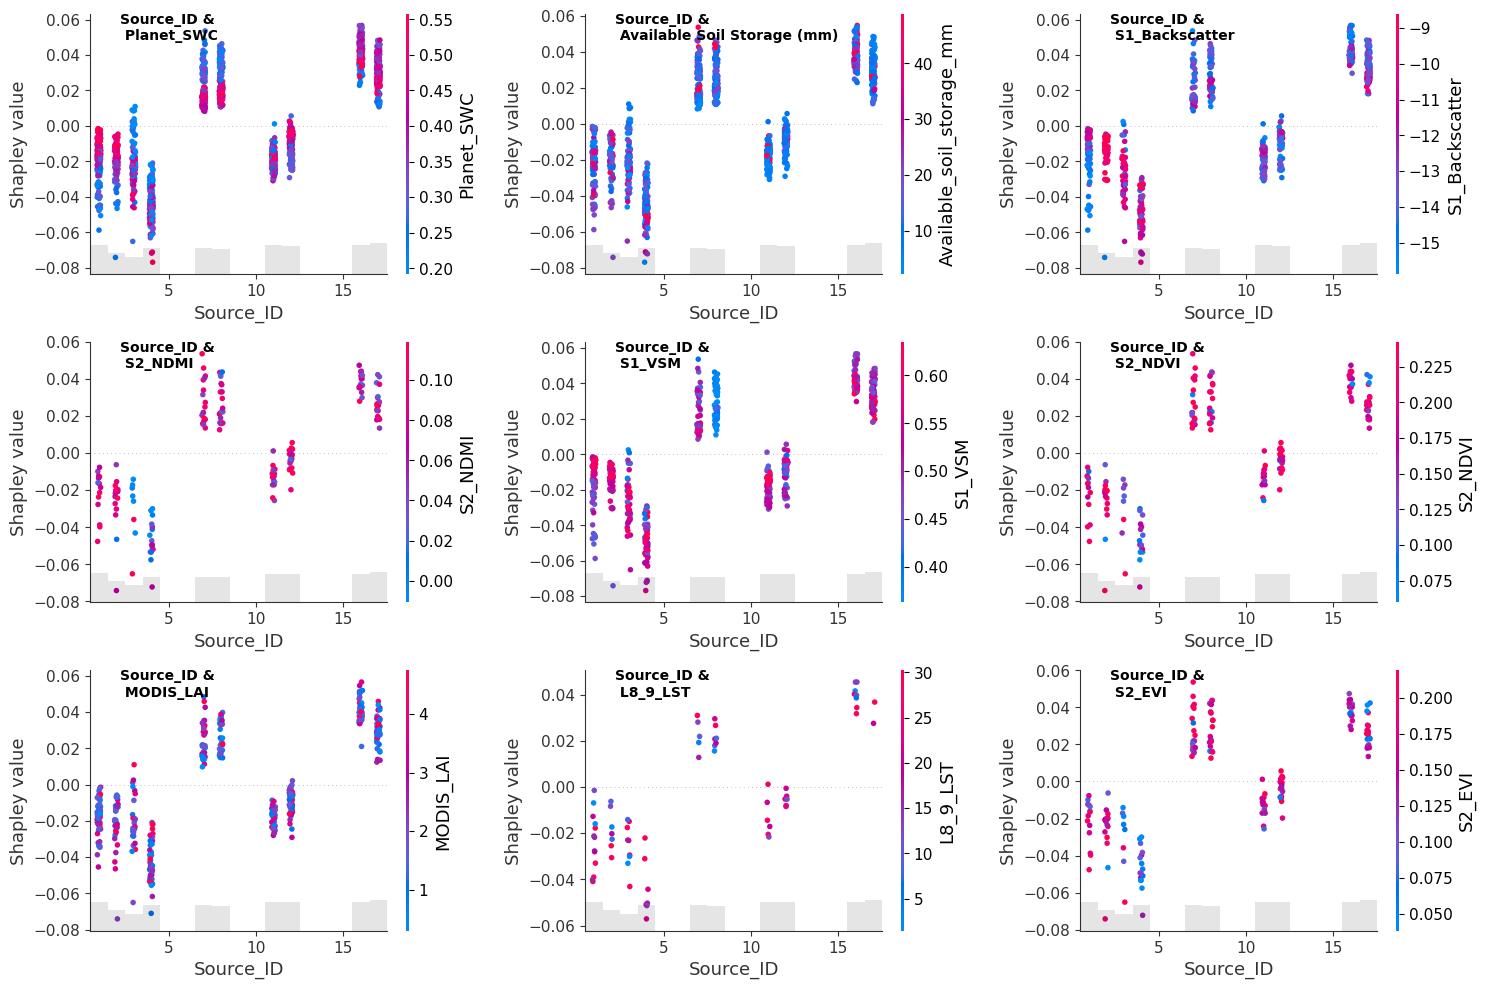

In [54]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

### AX1 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'Planet_SWC'], 
                   show=False,ax=ax1,ylabel=None)
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('Source_ID')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'Source_ID &\n Planet_SWC', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'Available_soil_storage_mm'],
                   show=False,ax=ax2,ylabel=None)
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('Source_ID')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'Source_ID &\n Available Soil Storage (mm)', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'S1_Backscatter'],
                   show=False,ax=ax3,ylabel=None)
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('Source_ID')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'Source_ID &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('Source_ID')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'Source_ID &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'], 
                   color=shap_values_explanation[:, 'S1_VSM'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('Source_ID')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'Source_ID &\n S1_VSM', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('Source_ID')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'Source_ID &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'MODIS_LAI'],
                   show=False,ax=ax7,ylabel=None)
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('Source_ID')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'Source_ID &\n MODIS_LAI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'], 
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax8,ylabel=None)
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('Source_ID')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'Source_ID &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Source_ID'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax9,ylabel=None)
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('Source_ID')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'Source_ID &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

#### Plot multiple Shapley scatter plots of S1_Backscatter

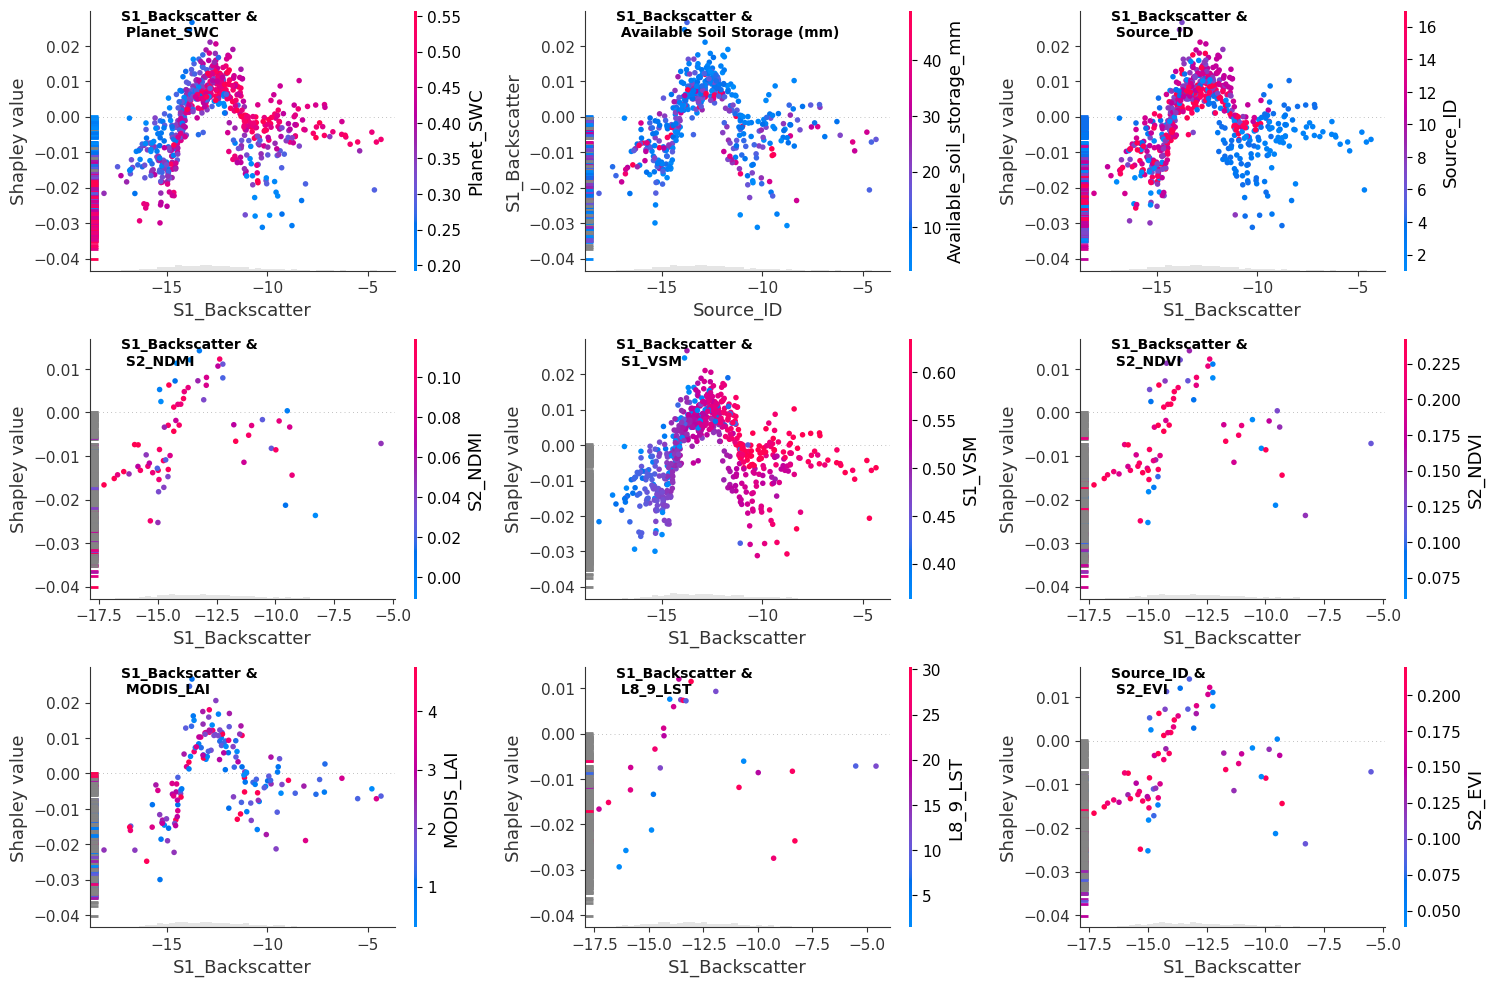

In [55]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

### AX1 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'Planet_SWC'], 
                   show=False,ax=ax1,ylabel=None)
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('S1_Backscatter')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'S1_Backscatter &\n Planet_SWC', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'Available_soil_storage_mm'],
                   show=False,ax=ax2,ylabel=None)
ax2.set_ylabel('S1_Backscatter')
ax2.set_xlabel('Source_ID')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'S1_Backscatter &\n Available Soil Storage (mm)', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'Source_ID'],
                   show=False,ax=ax3,ylabel=None)
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('S1_Backscatter')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'S1_Backscatter &\n Source_ID', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('S1_Backscatter')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'S1_Backscatter &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'], 
                   color=shap_values_explanation[:, 'S1_VSM'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('S1_Backscatter')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'S1_Backscatter &\n S1_VSM', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('S1_Backscatter')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'S1_Backscatter &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'MODIS_LAI'],
                   show=False,ax=ax7,ylabel=None)
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('S1_Backscatter')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'S1_Backscatter &\n MODIS_LAI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'], 
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax8,ylabel=None)
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('S1_Backscatter')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'S1_Backscatter &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax9,ylabel=None)
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('S1_Backscatter')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'Source_ID &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

#### Plot multiple Shapley scatter plots of S1_VSM

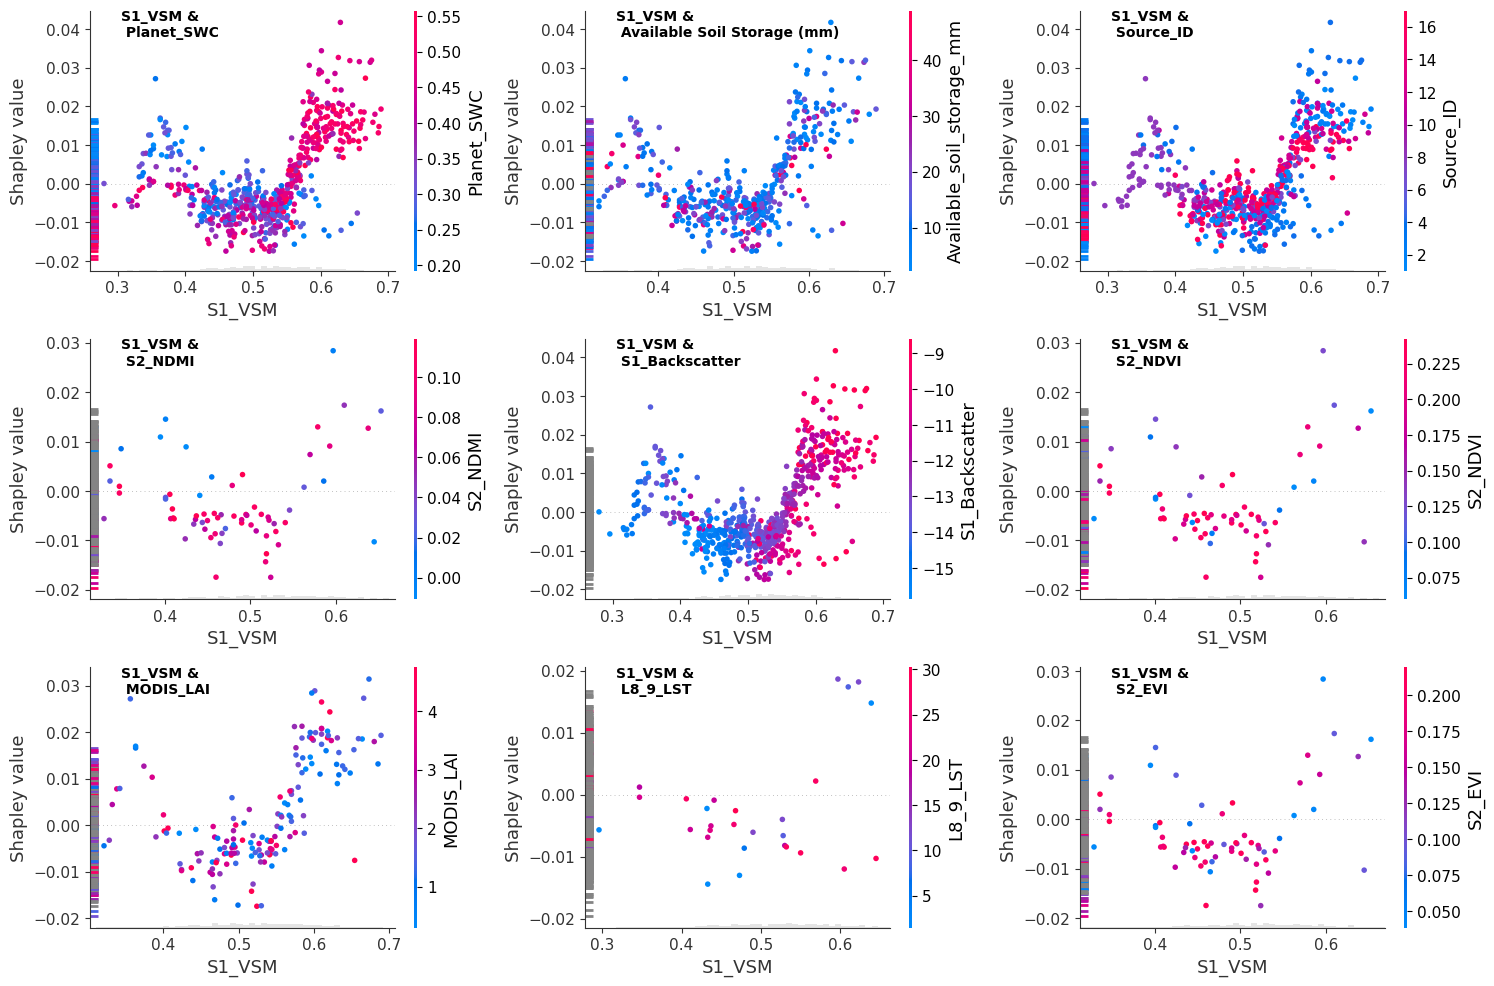

In [56]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))

### AX1 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'Planet_SWC'], 
                   show=False,ax=ax1,ylabel=None)
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('S1_VSM')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'S1_VSM &\n Planet_SWC', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'Available_soil_storage_mm'],
                   show=False,ax=ax2,ylabel=None)
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('S1_VSM')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'S1_VSM &\n Available Soil Storage (mm)', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'Source_ID'],
                   show=False,ax=ax3,ylabel=None)
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('S1_VSM')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'S1_VSM &\n Source_ID', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('S1_VSM')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'S1_VSM &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'], 
                   color=shap_values_explanation[:, 'S1_Backscatter'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('S1_VSM')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'S1_VSM &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('S1_VSM')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'S1_VSM &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'MODIS_LAI'],
                   show=False,ax=ax7,ylabel=None)
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('S1_VSM')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'S1_VSM &\n MODIS_LAI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'], 
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax8,ylabel=None)
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('S1_VSM')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'S1_VSM &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax9,ylabel=None)
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('S1_VSM')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'S1_VSM &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

#### Plot one shapley scatter plot individually 

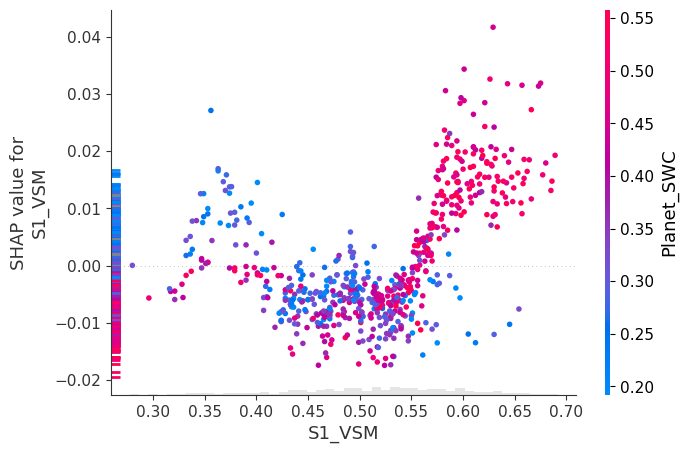

In [18]:
# Scatter plot for a specific feature (e.g., 'S1_VSM')
shap.plots.scatter(shap_values_explanation[:, 'S1_VSM'], color=shap_values_explanation[:,'Planet_SWC'])